In [1]:
import mlflow

Mlflow is an experiment tracking platform. It has database (called tracking uri/uri) and the folders later created.

To launch UI in localhost:5000:

!mlflow ui --backend-store-uri sqlite:///mlflow.db

# What is the version of mlflow? 

In [2]:
!mlflow --version

mlflow, version 2.3.2


Link to download:
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [3]:
!wget -P ./data/ https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet
!wget -P ./data/ https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet
!wget -P ./data/ https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-03.parquet

--2023-06-04 14:19:34--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.161.108.184, 18.161.108.77, 18.161.108.141, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.161.108.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254291 (1.2M) [binary/octet-stream]
Saving to: './data/green_tripdata_2022-01.parquet'

     0K .......... .......... .......... .......... ..........  4%  250K 5s
    50K .......... .......... .......... .......... ..........  8%  368K 4s
   100K .......... .......... .......... .......... .......... 12%  361K 3s
   150K .......... .......... .......... .......... .......... 16%  686K 3s
   200K .......... .......... .......... .......... .......... 20%  340K 3s
   250K .......... .......... .......... .......... .......... 24%  354K 3s
   300K .......... .......... .......... .......... ........

In [4]:
!python preprocess_data.py --raw_data_path ./data/ --dest_path ./output/

# What is the size of dv.pkl? 

In [5]:
size = !cd ./output/ & dir /a /s "dv.pkl" | findstr "dv.pkl" | (for /f "tokens=3" %F in ('findstr /r "[0-9][0-9]* .*dv.pkl"') do @echo %F)
size = int(size[0].strip().replace(',', ''))/1024

print(f'The filesize is {size:.2f} kb')

The filesize is 150.06 kb


# The value of maximum depth parameter

In [6]:
!python train.py --data_path ./output/

2023/06/04 14:19:59 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/06/04 14:19:59 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [7]:
from mlflow.entities import ViewType

In [8]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("nyc-2022")
runs = mlflow.search_runs(
    run_view_type=ViewType.ACTIVE_ONLY,
    filter_string='tags."problem" = "3"'
)

In [9]:
# Alternatives
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = 'sqlite:///mlflow.db'
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

runs = client.search_runs(
    experiment_ids='1',
    run_view_type=ViewType.ACTIVE_ONLY,
)

In [10]:
max_depth = runs[0].data.params['max_depth']

print(f'The max_depth is {max_depth}')

The max_depth is 10


# Tune model hyperparameter : best validation RMSE

In [11]:
!python hpo.py --data_path ./output/ --num_trials 10

2023/06/04 14:20:41 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-hyperopt' does not exist. Creating a new experiment.
[I 2023-06-04 14:20:41,980] A new study created in memory with name: no-name-2c5c780c-ec76-414f-8fb4-6130b7962398
[I 2023-06-04 14:20:44,310] Trial 0 finished with value: 2.451379690825458 and parameters: {'n_estimators': 25, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 2.451379690825458.
[I 2023-06-04 14:20:44,634] Trial 1 finished with value: 2.4667366020368333 and parameters: {'n_estimators': 16, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 2.451379690825458.
[I 2023-06-04 14:20:46,620] Trial 2 finished with value: 2.449827329704216 and parameters: {'n_estimators': 34, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 2.449827329704216.
[I 2023-06-04 14:20:47,451] Trial 3 finished with value: 2.460983516558473 a

In [12]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("random-forest-hyperopt")
runs = mlflow.search_runs(
    run_view_type=ViewType.ACTIVE_ONLY,
    order_by=["metrics.rmse ASC"]
)

In [13]:
best_rmse = runs['metrics.rmse'][0]

print(f'The best rmse is {best_rmse:.2f}')

The best rmse is 2.45


# Promote the best model to registry : best test RMSE

In [16]:
!python register_model.py --data_path ./output/ --top_n 5

{'n_estimators': '34', 'max_depth': '15', 'min_samples_split': '2', 'min_samples_leaf': '4', 'random_state': '42', 'n_jobs': '-1'}

2023/06/04 14:24:15 INFO mlflow.tracking.fluent: Experiment with name 'random-forest-best-models' does not exist. Creating a new experiment.
2023/06/04 14:24:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ALVIN RACHMAT\datatalks-homework2\.env\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils."
Successfully registered model 'random-forest-best-models'.
2023/06/04 14:24:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: random-forest-best-models, version 1
Created version '1' of model 'random-forest-best-models'.



{'n_estimators': '25', 'max_depth': '20', 'min_samples_split': '8', 'min_samples_leaf': '3', 'random_state': '42', 'n_jobs': '-1'}
{'n_estimators': '28', 'max_depth': '16', 'min_samples_split': '3', 'min_samples_leaf': '3', 'random_state': '42', 'n_jobs': '-1'}
{'n_estimators': '22', 'max_depth': '11', 'min_samples_split': '5', 'min_samples_leaf': '2', 'random_state': '42', 'n_jobs': '-1'}
{'n_estimators': '12', 'max_depth': '19', 'min_samples_split': '10', 'min_samples_leaf': '4', 'random_state': '42', 'n_jobs': '-1'}


In [17]:
model_name = 'random-forest-best-models'
latest_versions = client.get_latest_versions(name=model_name)

best_run_id = latest_versions[0].run_id

for version in latest_versions:
    print(f"version registry now: {version.version}, stage: {version.current_stage}")

version registry now: 1, stage: None


In [18]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("random-forest-best-models")
registry_test_rmse = mlflow.get_run(best_run_id).data.metrics['test_rmse']

print(f"Best test rmse : {registry_test_rmse:.2f}")

Best test rmse : 2.29


# Information in model registry

Here is the UI of the best model registry

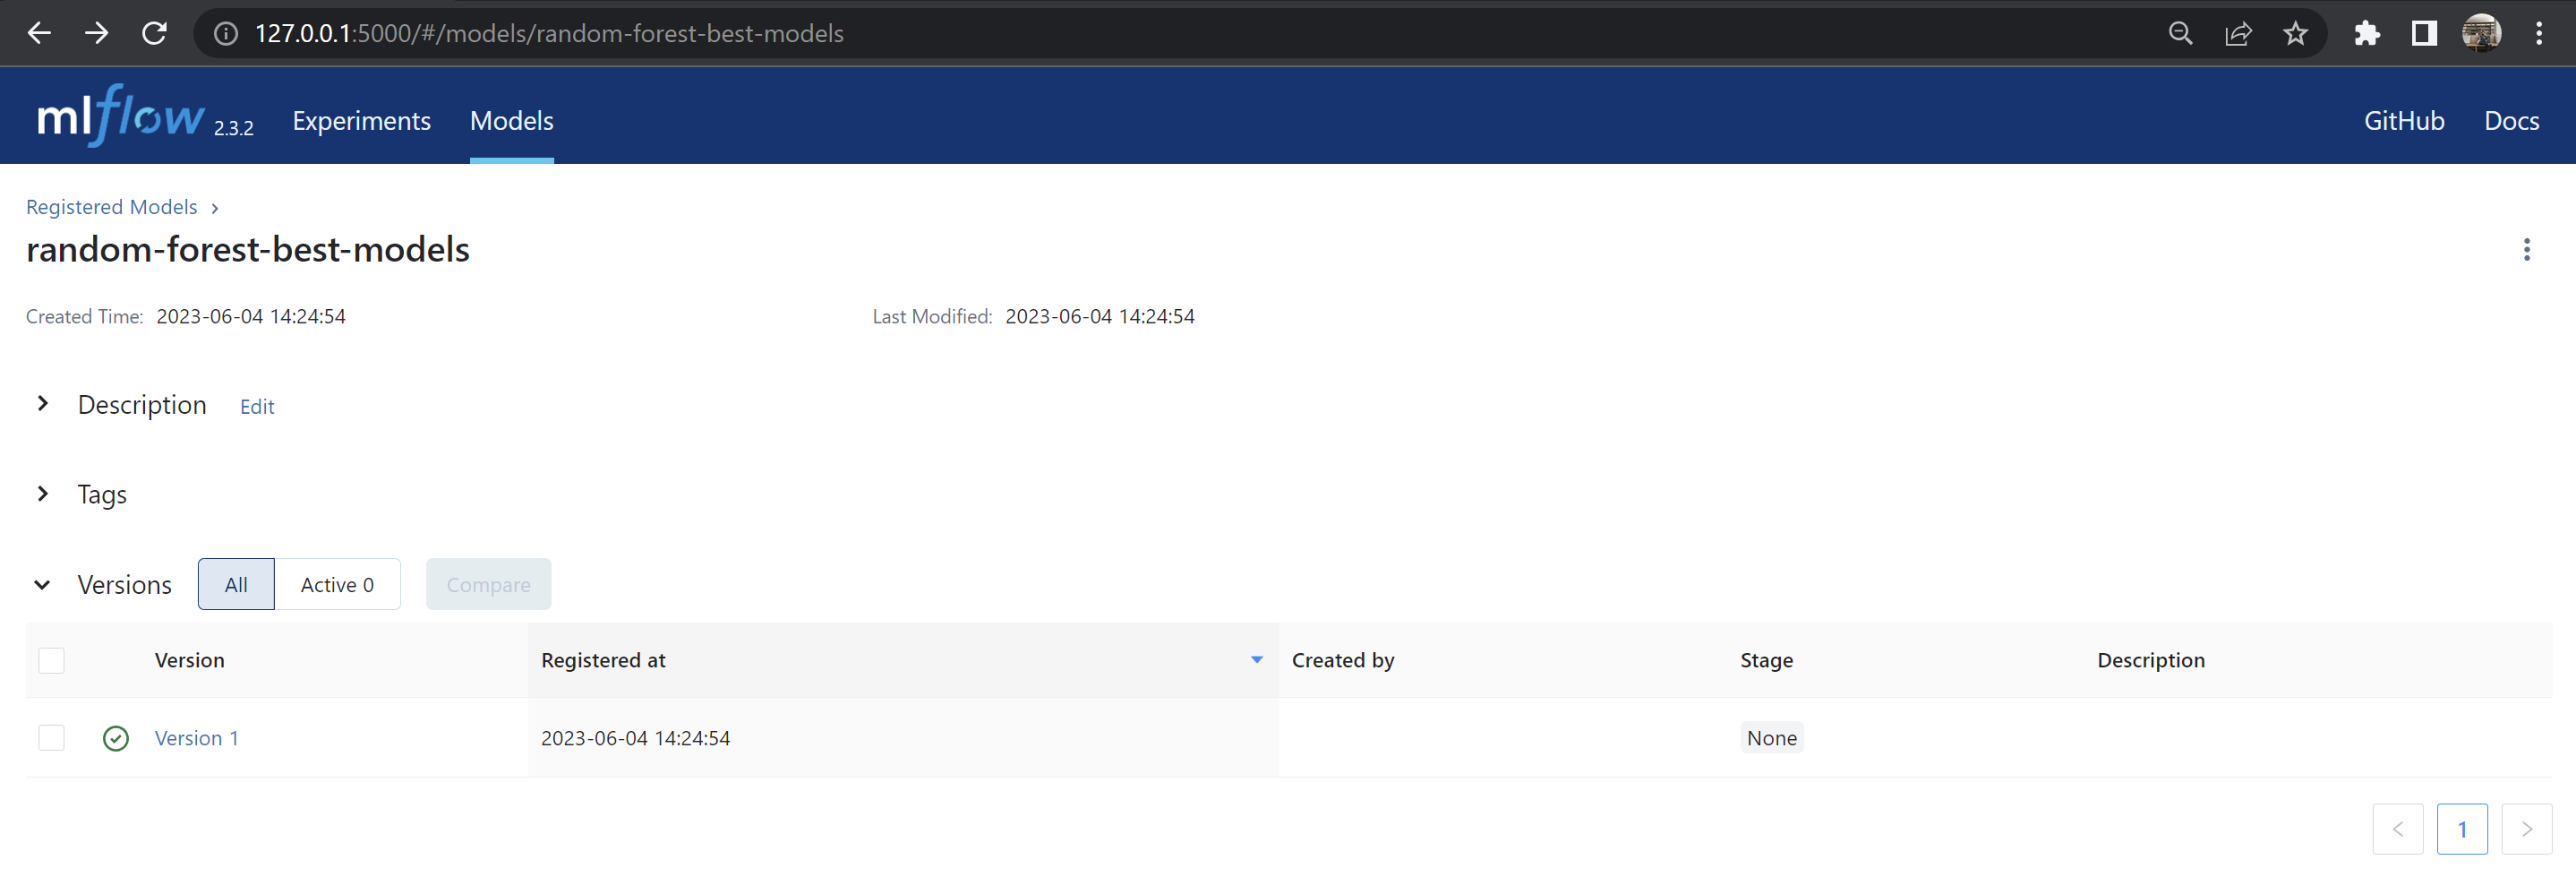

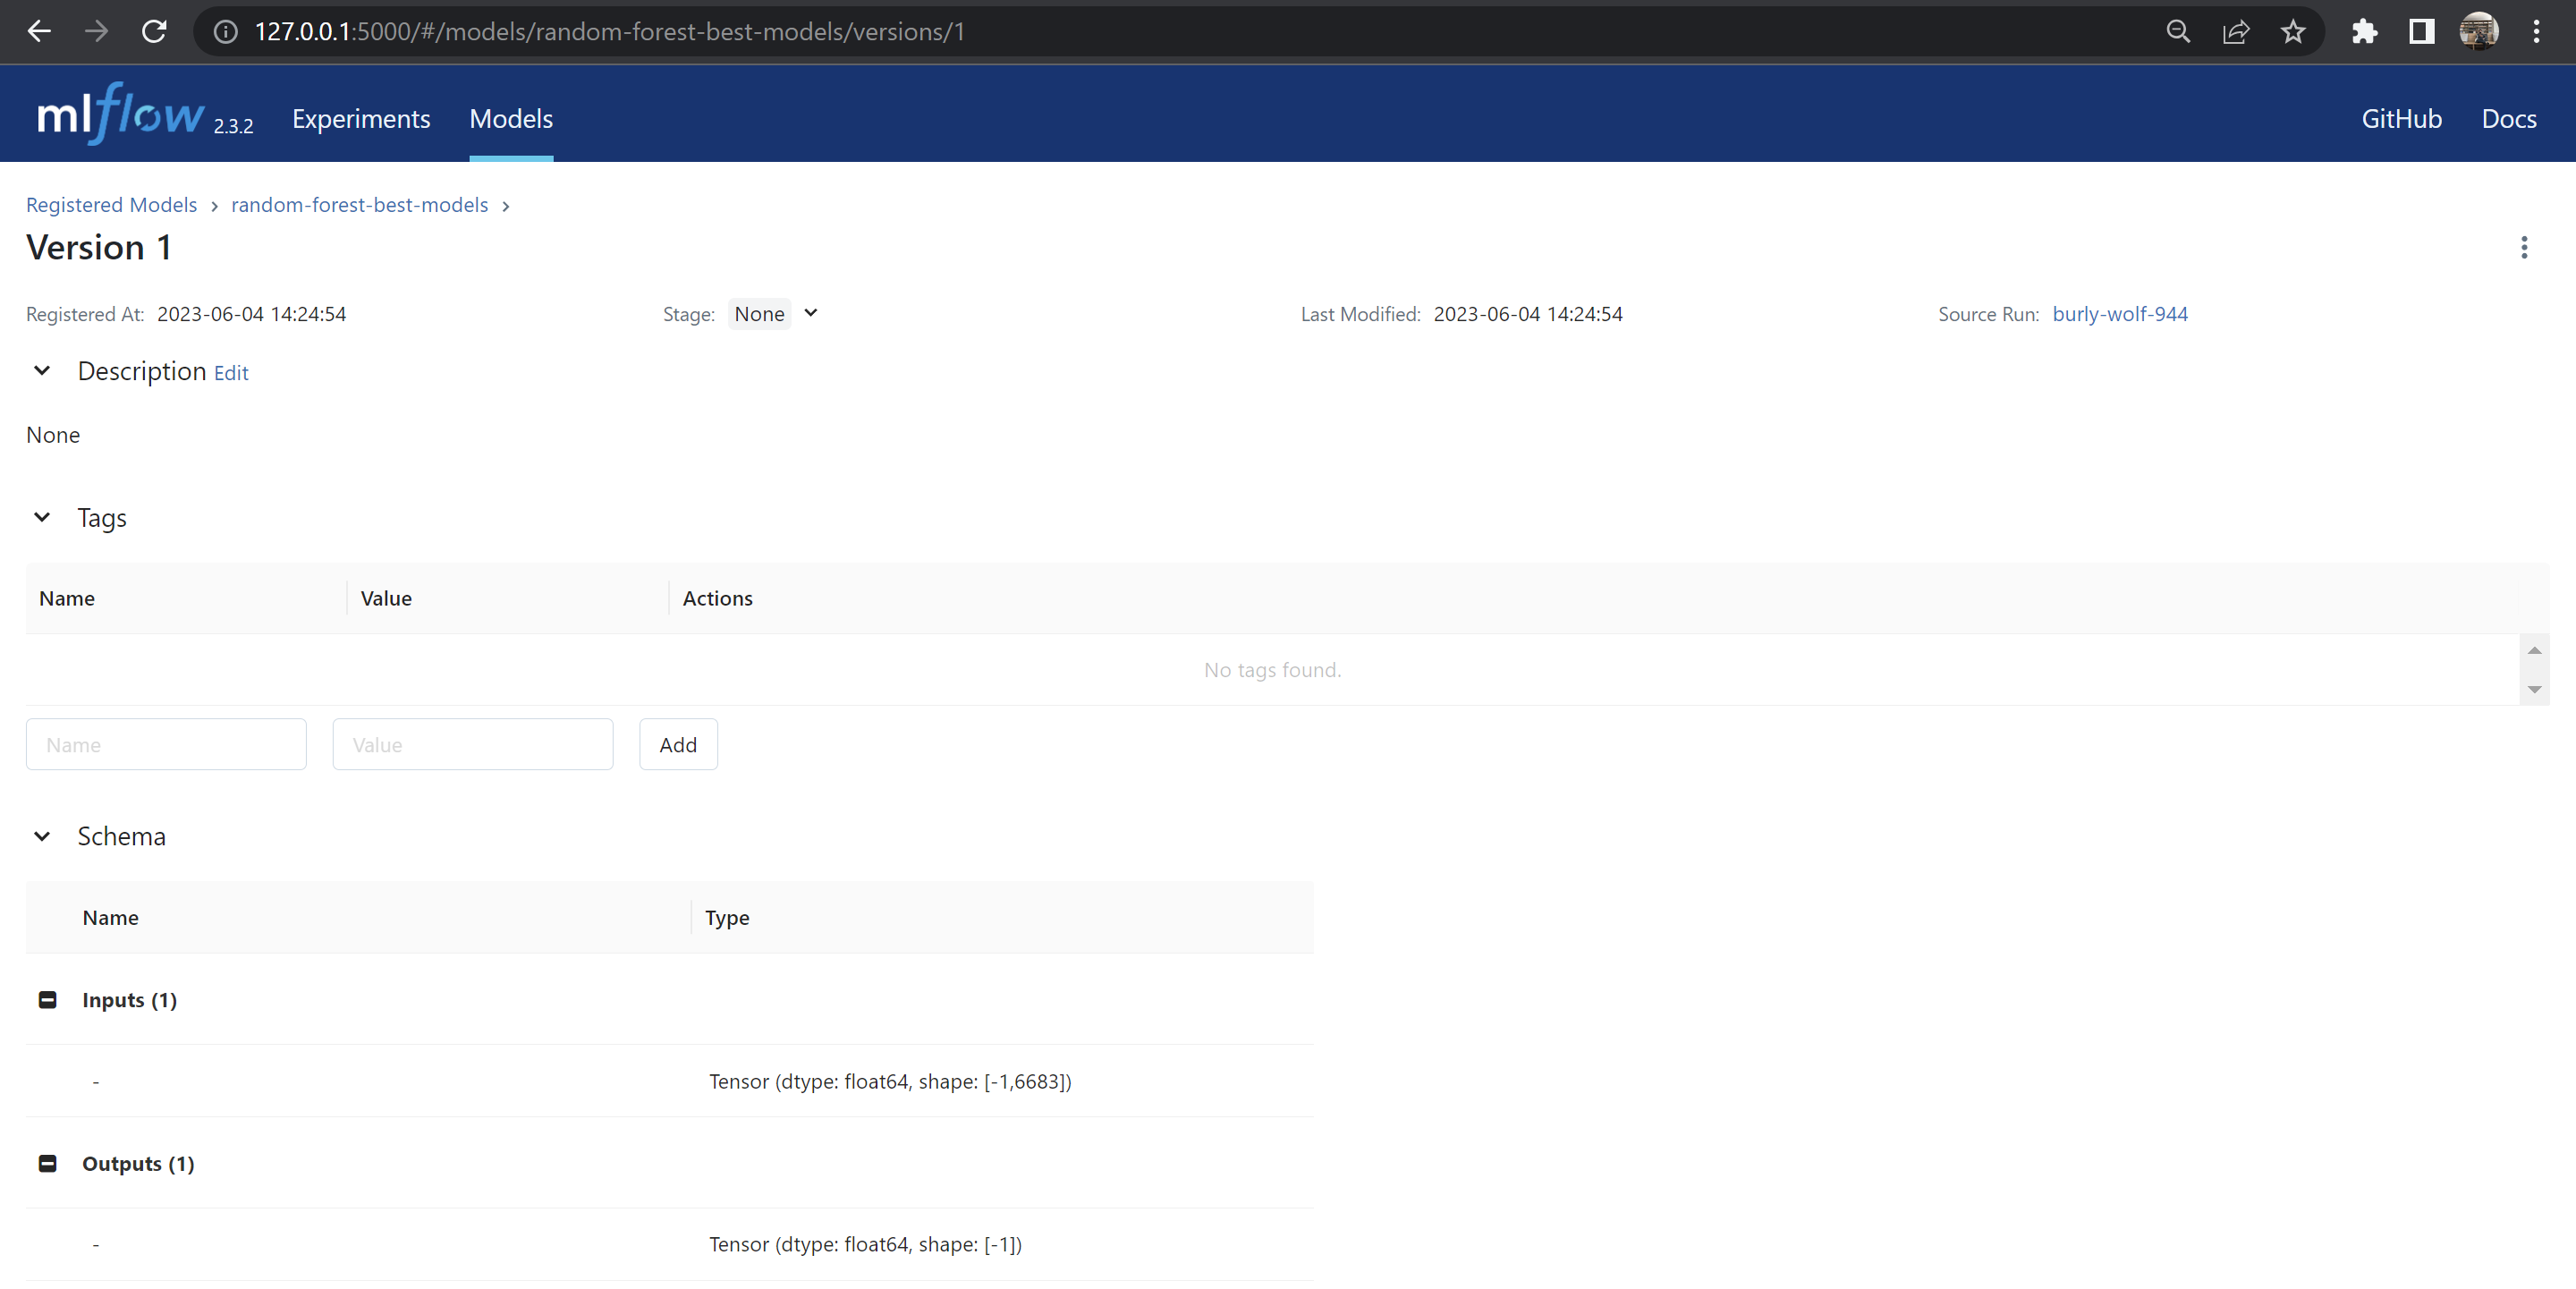

There are version number, source of run (experiment) and model signature (below the schema) we can refer.